In [1]:
import gc
import math
import itertools

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

import scipy.stats as st
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, DBSCAN, OPTICS

import infoStructure as ins
import helpers as hp
import clustering as cl
import display as dp
import importlib #importlib.reload(foo)

> Point to the directories (output for the processed mat files and where the mat files reside

In [2]:
INPUTDir = '' # the directory where the all the patients are (RS1000, RS10001...)
OUTPUTDir = '/output/'

> Grab all the patients directory that you need, and the specific features from the 34

<span style="color:red">Just needed to extract information. If needed, remove the tripple quotes</span>
```python
""" commented code """
```

In [3]:
"""
qty = 550 # max num of patients = 524
## randomly
feat_dict = ins.addAllPatientsInfoV4(INPUTDir, ['vectorRRKLD', 'vectorFAmpKLD', 'vectorUFAmpKLD', 'vectorCorrKLD'], qty)
"""
## in order, starting from N # of directory, qty = number of directories
#start_from = 0
#feat_dict = ins.addAllPatientsInfoV3(I NPUTDir, ['vectorRRKLD', 'vectorFAmpKLD', 'vectorUFAmpKLD', 'vectorCorrKLD'], qty, start_from)

"\nqty = 550 # max num of patients = 524\n## randomly\nfeat_dict = ins.addAllPatientsInfoV4(INPUTDir, ['vectorRRKLD', 'vectorFAmpKLD', 'vectorUFAmpKLD', 'vectorCorrKLD'], qty)\n"

> Transform into dict and save

<span style="color:red">Just needed to extract information. If needed, remove the tripple quotes</span>
```python
""" commented code """
```

In [4]:
## each feature must be listed here from the ones uploaded to memory in the step before
"""
vectorRRKLD_ALL = feat_dict['vectorRRKLD']
vectorFAmpKLD_ALL = feat_dict['vectorFAmpKLD']
vectorUFAmpKLD_ALL = feat_dict['vectorUFAmpKLD']
vectorCorrKLD_ALL = feat_dict['vectorCorrKLD']

df_ALL = hp.convertDictInDF(hp.putDataInDict(
        [vectorRRKLD_ALL, vectorFAmpKLD_ALL, vectorUFAmpKLD_ALL, vectorCorrKLD_ALL],
        ['vectorRRKLD_ALL', 'vectorFAmpKLD_ALL', 'vectorUFAmpKLD_ALL', 'vectorCorrKLD_ALL']
    ))

df_ALL.to_feather(OUTPUTDir + str(qty) + '.feather') # save

del feat_dict, df_ALL, vectorRRKLD_ALL, vectorFAmpKLD_ALL, vectorUFAmpKLD_ALL, vectorCorrKLD_ALL; gc.collect()
"""

"\nvectorRRKLD_ALL = feat_dict['vectorRRKLD']\nvectorFAmpKLD_ALL = feat_dict['vectorFAmpKLD']\nvectorUFAmpKLD_ALL = feat_dict['vectorUFAmpKLD']\nvectorCorrKLD_ALL = feat_dict['vectorCorrKLD']\n\ndf_ALL = hp.convertDictInDF(hp.putDataInDict(\n        [vectorRRKLD_ALL, vectorFAmpKLD_ALL, vectorUFAmpKLD_ALL, vectorCorrKLD_ALL],\n        ['vectorRRKLD_ALL', 'vectorFAmpKLD_ALL', 'vectorUFAmpKLD_ALL', 'vectorCorrKLD_ALL']\n    ))\n\ndf_ALL.to_feather(OUTPUTDir + str(qty) + '.feather') # save\n\ndel feat_dict, df_ALL, vectorRRKLD_ALL, vectorFAmpKLD_ALL, vectorUFAmpKLD_ALL, vectorCorrKLD_ALL; gc.collect()\n"

** Grab the information previously treated and saved as a feather file **

In [5]:
name_of_file = '550_32.feather'
df_ALL = pd.read_feather(OUTPUTDir + name_of_file)

** According to the quantity of the memory available, grab randomly the rows for the study of the data **
> 0.22 (22%) for a 16Go RAM memory avaliable computer, for one model

> 0.16 for a 16Go RAM memory available computer, for running several models (like GMM but several times to get the best BIC score)

In [6]:
df_DIV, indexes = hp.getRandomRows(df_ALL, 0.1)

### Preprocessing

In [7]:
df_DIV = cl.cleanData(df_DIV, 'mean') # impute non available data in the columns using a strategy (mean, median, most_frequent)

> Dependign if PCA wants to be applied, run one or the other, in this step, removing outliers and normalization takes place

> Besides, in order to to a hard removela for the difficult "vectorUFAmpKLD" feature removal, choose v3=True for the runOutNormV2, else, if just wanted it to be handled with the meanshift appraoch, use v3=False

In [8]:
df_nout, Xnorm, std, indexes2 = cl.runOutNormV2(df_DIV, indexes, threshold=20, threshold_hard=0.01, v3=True)
## for PCA run this one
#df_nout, Xnorm, Xpca, dfPca, titPca, pca, std, indexes2 = cl.runOutNormPCAV2(df_DIV, indexes, threshold=20, threshold_hard=0.01, cols_hard=[0,2])

bandwidth: 762201184825.3744
number of estimated clusters : 764
shapes: (12012806,), (12012806, 4)
shapes: (12010469,), (12010469, 4)
tomain [ True  True  True ...  True  True  True]
after hard removal (vectorUFAmpKLD && vectorRRKLD) shape : (11999961, 4) && 99.89
after soft removal (vectorCorrKLD && vectorFAmpKLD) shape : (12010469, 4) && 99.98


> declare which matrix of data should be used for the models according to the previous choice

In [9]:
X = Xnorm # Xnorm or Xpca

> print data as obtained from preprocessing, 
 ```python
if Xpca, the "titPca" variable should be passed,
else titles of columns should be passed (['vectorRRKLD', 'vectorFAmpKLD', 'vectorUFAmpKLD', 'vectorCorrKLD'])
```

In [10]:
titles = ['vectorRRKLD', 'vectorFAmpKLD', 'vectorUFAmpKLD', 'vectorCorrKLD']

In [11]:
#dp.printPCAScatter(df_nout, titles)
del df_nout; gc.collect()
# del dfPca; gc.collect()

0

### Model

```python 
if used v3=False for the preprorcessing step (runOutNormV2 function), components should be around 8 and 10
else components are around 6 and 8
```

In [12]:
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue', 'darkorange', 'gold', 'tomato', 'crimson', 'darkslategray', 'springgreen', 'chocolate'])

In [13]:
gmm9 = GaussianMixture(n_components=9, covariance_type='full').fit(X)
#gmm10 = GaussianMixture(n_components=10, covariance_type='full').fit(X)

> ** TO PRINT**

```python
# for 2d prinring of all clusters together (6 images), use: 
dp.printPCAGMM(gmm_to_print, X, titles, color_iter)
# for 2d printing of one cluster, use next: 
# ( gmm, gmm.predict(X), cluster #, column_1_to_display, column_2_to_display, color_of_cluster, titles )
dp.plotOneGMMCluster(gmm_to_print, predicted, 0, 0, 1, 'turquoise', titles)
# for 3d printing of onw cluster, use next: 
# ( 3dfig, gmm, gmm.predict(X), cluster #, column_1_to_display, column_2_to_display, column_3_to_display, color_of_cluster, titles)
ax = plt.axes(projection='3d') # just once!!
dp.plotOneGMMCluster3D(ax, gmm_to_print, predicted, 2, 0, 1, 2, 'turquoise', titles)
```

> <span style="color:red">put one plot by cell, if not, dynamic display wont appear for each plot</span>

In [14]:
importlib.reload(dp)

<module 'display' from '/homes/v18porti/Documents/code/imt_stg/display.py'>

In [15]:
# to show a dinamic view, if not desired, use "%matplotlib inline"
%matplotlib notebook 
gmm_to_print = gmm9
predicted = gmm_to_print.predict(X)

** For each cluster, and for different features, the next cell chould be modified taking into accunt the variables mentioned above ** 

*Since just one cluster colored by 2 cells considering 4 dimensions, 2 plots must be donne to show each cluster according the 4 dimensions in a 3d plot*

<IPython.core.display.Javascript object>


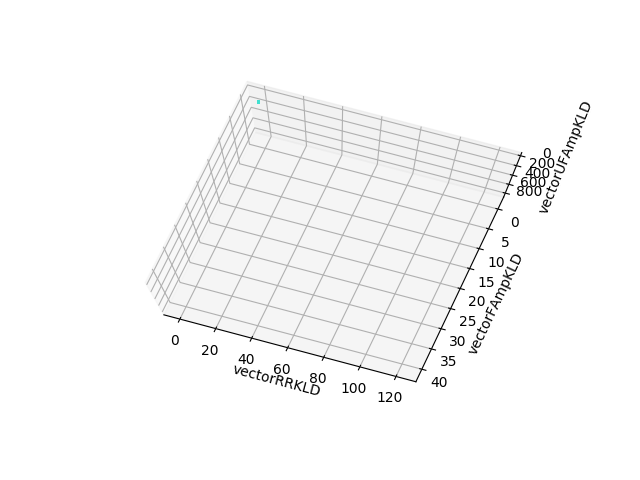

In [25]:
ax = plt.axes(projection='3d')
dp.plotOneGMMCluster3D(ax, X, predicted, 2, 0, 1, 2, 'turquoise', titles)
plt.show()

### Understand de BIC (Bayesian Information Criterion) Optional
> If runned, take into account the percentage of data from the total, for a 16Go computer it will only support 15% og the 120 million rows with 4 features in float32

In [ ]:
"""
n_components_range = range(5, 19)
best_gmm, bic, cv_types = cl.getBestGMMUsingBIC(X, n_components_range, ['full'], 0.1)
bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue', 'darkorange', 'gold', 'tomato', 'crimson', 'darkslategray', 'springgreen', 'chocolate'])
dp.plotBICScores(bic, cv_types, color_iter, n_components_range)
"""